# Deep Learning: backpropagation

Dans cette deuxième session, nous allons plonger plus en profondeur dans le concept de rétropropagation du gradient (backpropagation) et des différentes méthodes d’optimisation (stochastique, lot complet, mini-lot) pour entraîner un réseau de neurones. Nous allons reprendre quelques notions fondamentales du forward pass vues lors de la première session, mais l’accent sera mis principalement sur la compréhension de la rétropropagation.

Nous utiliserons le **dataset** MNIST des chiffres manuscrits, une référence classique, afin d'illustrer de manière concrète ces concepts. Nous aborderons :

- Le rappel du passage avant (forward pass) en quelques mots.
- La compréhension de la rétropropagation (backpropagation) : pourquoi et comment cela permet d’actualiser les poids.
- Les méthodes de descente de gradient : descente de gradient par lot (batch), stochastique (SGD), et par mini-lots (mini-batch).
- Le rôle du taux d'apprentissage (learning rate).
- L’importance de la convexité et la difficulté des fonctions de coût non-convexes.
- La mise en place d'un réseau de neurones simple sur MNIST avec Keras.
- L’entraînement du modèle avec différentes stratégies et la visualisation des résultats.


## Rappel sur le passage avant (Forward Pass)

Le passage avant consiste à prendre une entrée (une image de chiffre manuscrit 28x28 pixels dans notre cas), à la faire passer à travers le réseau couche par couche, jusqu’à obtenir une prédiction (par exemple, un vecteur de probabilités pour les 10 classes de chiffres).

Ce passage est une suite d'opérations linéaires (multiplications matricielles) et non linéaires (fonctions d'activation), jusqu'à la couche de sortie. Une fois que le réseau a produit sa sortie, nous pouvons calculer une fonction de coût (loss) qui quantifie à quel point la prédiction est éloignée de la réalité.


## La rétropropagation (backpropagation)

La rétropropagation est la méthode systématique pour ajuster les poids du réseau afin de réduire l’erreur du réseau sur les données d’entraînement. Il utilise le fait que la fonction de coût est différentiable par rapport aux poids. Par la règle de la chaîne, on calcule la dérivée du coût par rapport aux sorties, puis on "remonte" couche par couche, ajustant ainsi les poids dans la direction qui réduit l’erreur.

Ce procédé est crucial : sans lui, il serait très difficile d’entraîner des réseaux neuronaux profonds. La rétropropagation utilise essentiellement la dérivation successive des opérations composant le réseau, et permet d’accumuler les gradients pour chaque paramètre.

Ce gradient indique la direction dans laquelle on doit ajuster les poids pour améliorer la performance du réseau.


## Les méthodes d’optimisation et la descente de gradient

Une fois que l'on dispose des gradients, il faut décider de la manière de les utiliser pour mettre à jour les poids. La descente de gradient (Gradient Descent) est la méthode la plus répandue.

Plusieurs variantes existent :

- **Descente de gradient par lot (Batch Gradient Descent)** : On calcule le gradient en utilisant **toutes** les données d’entraînement. Cette méthode est exacte mais très lente sur de grands ensembles de données.
- **Descente de gradient stochastique (Stochastic Gradient Descent, SGD)** : On calcule le gradient et met à jour les poids après **chaque exemple** pris individuellement. Cette méthode est très rapide, mais noisy (beaucoup de variance dans l’estimation du gradient).
- **Descente de gradient par mini-lots (Mini-Batch Gradient Descent)** : On calcule le gradient sur un **sous-ensemble (mini-lot)** de données (par exemple 32, 64, 128 exemples), puis on met à jour les poids. C’est un compromis largement adopté en pratique, car il combine la stabilité de l’estimation du gradient (moins noisy que le purement stochastique) et une certaine rapidité (plus rapide que le pur batch sur de gros ensembles).

**Le taux d’apprentissage (learning rate)** est le pas que l’on fait dans la direction du gradient. Un taux trop élevé conduit à des oscillations, voire à une divergence de l’entraînement. Un taux trop faible conduit à une convergence très lente, voire à un piégeage dans un minimum local. De bonnes techniques consistent à ajuster dynamiquement le learning rate, ou à utiliser des optimisateurs plus avancés (Adam, RMSProp, etc.).

### Convexité

Il est important de noter que la fonction de coût d’un réseau de neurones profond n’est pas convexe, contrairement, par exemple, à la régression linéaire. Cela signifie qu’on peut se retrouver bloqué dans des minima locaux ou des vallées complexes. Le but de la descente de gradient est de s’améliorer petit à petit, même si la solution finale peut ne pas être le minimum global.

Passons maintenant à une implémentation pratique avec Keras.


## Importation des bibliothèques nécessaires

Avant tout, importons les bibliothèques. Nous utiliserons Keras (via TensorFlow), Matplotlib pour la visualisation, et Numpy pour la manipulation numérique.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

## Chargement et préparation du dataset MNIST

MNIST est un dataset de 70,000 images de chiffres manuscrits (0 à 9). Chaque image est en niveaux de gris, 28x28 pixels. Nous allons charger ce dataset, le normaliser, et le séparer en données d'entraînement et de test.


In [ ]:
# On charge les données MNIST fournies par Keras.
# x_train et x_test sont des tableaux 3D (nb_images, 28, 28)
# y_train et y_test sont les étiquettes (0 à 9).
# On va normaliser les pixels en [0,1] et transformer les étiquettes en catégories one-hot si nécessaire.

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# On peut éventuellement aplatir les images ou les garder en 2D.
# Keras s'adapte si on utilise des couches Dense, il faut aplatir.
# On va aplatir: chaque image 28x28 devient un vecteur de 784.
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

# Les étiquettes sont des entiers entre 0 et 9. Dans un réseau de classification,
# on utilise souvent "sparse_categorical_crossentropy", donc pas besoin de one-hot.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


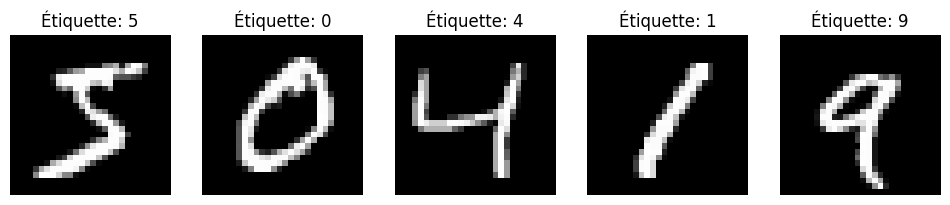

In [ ]:
# Nous allons afficher quelques images du dataset
# Juste pour nous assurer que nos données sont bien chargées et familiariser visuellement.

fig, axes = plt.subplots(1, 5, figsize=(12,3))
for i in range(5):
    axes[i].imshow(x_train[i].reshape(28,28), cmap='gray')
    axes[i].set_title(f"Étiquette: {y_train[i]}")
    axes[i].axis('off')
plt.show()

## Construction d’un réseau simple

Nous allons construire un simple réseau entièrement connecté avec une couche cachée. Puis nous le compilerons avec un optimiseur SGD simple pour illustrer la descente de gradient.

**Architecture proposée**:
- Entrée: 784 neurones (correspondant à l’image aplatit 28x28)
- Couche cachée: 64 neurones, activation ReLU
- Sortie: 10 neurones, activation softmax (distribution de probabilité sur les classes)

**Fonction de coût (loss)**: `sparse_categorical_crossentropy`  
**Métrique**: `accuracy`  
**Optimiseur**: SGD (descente de gradient stochastique) avec un certain taux d’apprentissage.

In [ ]:
# Nous construisons le modèle avec Keras.
# Après, nous compilerons le modèle avec SGD et un learning rate donné.

model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(784,)),
    layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.1),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Entraînement du modèle

Nous allons entraîner ce réseau sur le dataset d’entraînement.  
Observons ce qui se passe lorsque l'on entraîne avec un certain batch_size. Par exemple, essayons un batch_size = 32, ce qui correspond au mini-batch gradient descent. Cela signifie que le gradient sera calculé et les poids mis à jour après chaque lot de 32 images.

Ce processus s’effectue ainsi:
1. Forward pass sur les 32 images.
2. Calcul de la perte.
3. Backpropagation: calcul du gradient par rapport aux poids.
4. Mise à jour des poids dans la direction qui réduit la perte.

Ce cycle se répète pour tous les mini-lots, puis on fait plusieurs époques (passes complètes sur le dataset).


In [ ]:
# Nous allons entraîner notre modèle pour quelques époques, en utilisant un batch_size de 32.
# Nous observerons l’évolution de la perte et de la précision.
# On stocke l'historique d'entraînement dans "history" pour plus tard visualiser.

history = model.fit(
    x_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(x_test, y_test),
    verbose=1
)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8598 - loss: 0.4860 - val_accuracy: 0.9501 - val_loss: 0.1672
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9540 - loss: 0.1596 - val_accuracy: 0.9614 - val_loss: 0.1285
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9673 - loss: 0.1158 - val_accuracy: 0.9657 - val_loss: 0.1125
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9716 - loss: 0.0968 - val_accuracy: 0.9675 - val_loss: 0.1053
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9755 - loss: 0.0807 - val_accuracy: 0.9721 - val_loss: 0.0902


### Observation des résultats

Regardons l'évolution de la perte et de la précision au cours de l'entraînement et sur le daatset de test.


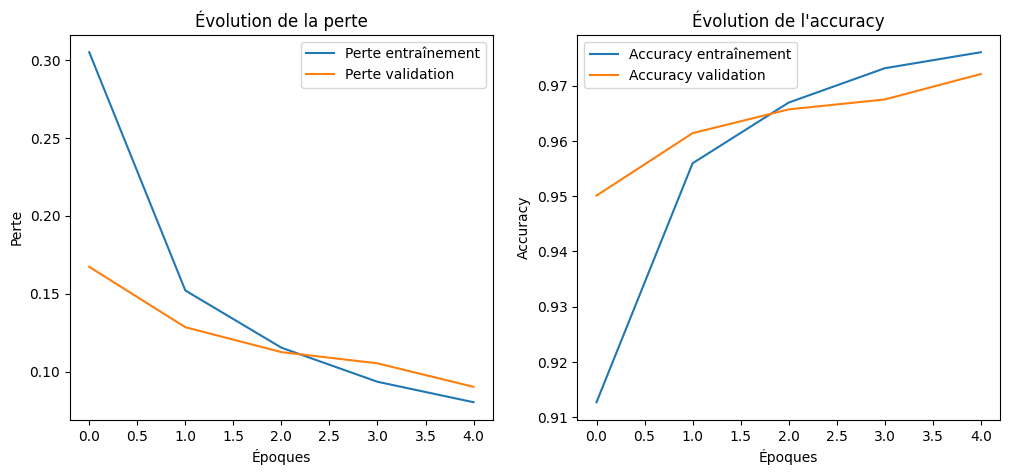

In [ ]:
# On va tracer la courbe d'entraînement (loss/accuracy) sur les époques
# Cela nous aide à visualiser l'effet de la descente de gradient.

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Perte entraînement')
plt.plot(history.history['val_loss'], label='Perte validation')
plt.title("Évolution de la perte")
plt.xlabel("Époques")
plt.ylabel("Perte")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Accuracy entraînement')
plt.plot(history.history['val_accuracy'], label='Accuracy validation')
plt.title("Évolution de l'accuracy")
plt.xlabel("Époques")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

## Comparaison Batch / Stochastique / Mini-Batch

- **Batch Gradient Descent**: Nous calculons le gradient sur **toutes** les images d’entraînement avant de faire une mise à jour.  
- **Stochastic Gradient Descent (SGD)**: On calcule le gradient après **chaque exemple**, donc batch_size=1.  
- **Mini-Batch**: Entre les deux extrêmes, par exemple batch_size=32.

Essayons d'entraîner avec batch_size=1 (stochastique) et avec batch_size=len(x_train) (une seule mise à jour par époque, batch complet), et comparons le temps, la stabilité et la convergence.

Notez que sur un dataset volumineux, le batch complet serait très lent, tandis que le stochastique pur peut être très bruité. Le mini-batch est le meilleur compromis.

**Attention**: Ici, MNIST est un petit dataset, donc la différence sera moins frappante. Mais c’est instructif.


In [ ]:
# Nous allons créer la même architecture mais entraîner avec un batch_size=1 (SGD pur).
# Cela montrera une convergence plus lente et plus bruitée en pratique.

model_sgd = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(784,)),
    layers.Dense(10, activation='softmax')
])

model_sgd.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.1),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_sgd = model_sgd.fit(
    x_train, y_train,
    epochs=3,
    batch_size=1,  # Stochastique pur
    validation_data=(x_test, y_test),
    verbose=1
)

Epoch 1/3
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 100s 2ms/step - accuracy: 0.6555 - loss: 1.2483 - val_accuracy: 0.6221 - val_loss: 1.3877
Epoch 2/3
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 97s 2ms/step - accuracy: 0.6740 - loss: 1.1709 - val_accuracy: 0.7245 - val_loss: 0.9949
Epoch 3/3
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 95s 2ms/step - accuracy: 0.7140 - loss: 1.0569 - val_accuracy: 0.7460 - val_loss: 0.8899


In [ ]:
# Maintenant, on teste le batch complet: batch_size = longueur du dataset d'entraînement.
# Cela fera une seule mise à jour par époque.

model_batch = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(784,)),
    layers.Dense(10, activation='softmax')
])

model_batch.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.1),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_batch = model_batch.fit(
    x_train, y_train,
    epochs=3,
    batch_size=len(x_train),  # Batch complet
    validation_data=(x_test, y_test),
    verbose=1
)

Epoch 1/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1059 - loss: 2.3221 - val_accuracy: 0.1591 - val_loss: 2.2379
Epoch 2/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step - accuracy: 0.1619 - loss: 2.2389 - val_accuracy: 0.2123 - val_loss: 2.1674
Epoch 3/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step - accuracy: 0.2209 - loss: 2.1705 - val_accuracy: 0.2773 - val_loss: 2.1032


#### **Explication supplémentaire :**

Il est important de distinguer la théorie de la pratique dans des contextes différents. Théoriquement, sur des datasets très volumineux, la descente de gradient par lot complet (Batch GD) est lente, car elle exige d’attendre que l’intégralité du dataset soit traitée avant chaque mise à jour des poids. La descente de gradient stochastique (SGD) et par mini-lots (Mini-Batch GD) permettent quant à elles d’effectuer des mises à jour fréquentes et donc, en général, d’avancer plus rapidement vers une solution acceptable. Cependant, dans le cas de MNIST, un dataset relativement petit, et sur un environnement matériel très optimisé comme Colab (avec GPU), le calcul sur l’ensemble des données peut être vectorisé et parallélisé de façon extrêmement efficace. Cela donne l’impression, dans ce contexte précis, que le batch complet est plus rapide, car l’opération est effectuée en un seul bloc très optimisé. En pratique, sur des datasets beaucoup plus grands, cette situation serait renversée, et le recours à la SGD ou aux mini-batchs deviendrait la solution réellement plus rapide et évolutive.

### Observation des différentes méthodes

Comparons leurs courbes de perte et d'accuracy. Cela nous donnera une intuition sur les avantages et inconvénients de chaque méthode.

Rappel:
- `history_sgd` : batch_size=1 (SGD)
- `history_batch` : batch_size=60000 (batch complet)
- `history` (le premier entraînement) : batch_size=32 (mini-batch)

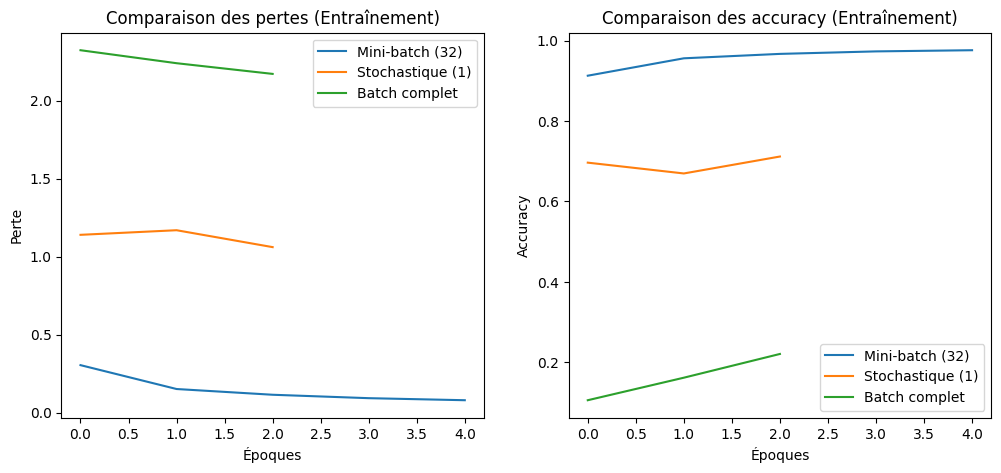

In [ ]:
# On trace les pertes et accuracy pour les trois méthodes.
# Cela nous permet de voir les différences de stabilité et rapidité de convergence.

plt.figure(figsize=(12,5))

# On compare la perte d'entraînement
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Mini-batch (32)')
plt.plot(history_sgd.history['loss'], label='Stochastique (1)')
plt.plot(history_batch.history['loss'], label='Batch complet')
plt.title("Comparaison des pertes (Entraînement)")
plt.xlabel("Époques")
plt.ylabel("Perte")
plt.legend()

# On compare l'accuracy d'entraînement
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Mini-batch (32)')
plt.plot(history_sgd.history['accuracy'], label='Stochastique (1)')
plt.plot(history_batch.history['accuracy'], label='Batch complet')
plt.title("Comparaison des accuracy (Entraînement)")
plt.xlabel("Époques")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

## Discussion sur les résultats

- **SGD (batch_size=1)** : On s’attend à une plus grande variabilité dans la perte et l’accuracy, car chaque mise à jour se fait sur un seul exemple. Ceci introduit du bruit dans la direction du gradient. Parfois, cela peut aider à sortir de minima locaux, mais c’est souvent moins stable.

- **Batch complet** : Mise à jour très stable (l’exact gradient sur tout le dataset), mais ne fait qu’une mise à jour par époque, ce qui peut être très lent pour de gros datasets. Ici, MNIST est petit, donc ça reste rapide, mais en pratique ce n’est pas scalable.

- **Mini-batch (par exemple 32)** : C’est en général un bon compromis. On a un calcul de gradient plus stable que le stochastique pur, et plusieurs mises à jour par époque qui rendent l’entraînement plus rapide que le batch complet.

En pratique, le mini-batch est la méthode de choix.

## Le rôle du taux d'apprentissage (learning rate)

Essayons maintenant un autre apprentissage avec un learning rate différent, pour voir son impact. Un learning rate trop grand peut empêcher la convergence, un learning rate trop petit ralentit énormément l’apprentissage.

In [ ]:
# Nous allons entraîner le même réseau avec un learning rate très élevé, disons 40.0,
# ce qui est extrêmement grand et montre souvent une divergence.

model_lr_high = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(784,)),
    layers.Dense(10, activation='softmax')
])

model_lr_high.compile(
    optimizer=keras.optimizers.SGD(learning_rate=40.0),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_lr_high = model_lr_high.fit(
    x_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(x_test, y_test),
    verbose=1
)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.0995 - loss: 18000364.0000 - val_accuracy: 0.0974 - val_loss: 12.7105
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.0991 - loss: 13.2733 - val_accuracy: 0.0892 - val_loss: 4.7606
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.1015 - loss: 12.8743 - val_accuracy: 0.0982 - val_loss: 12.7916
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.0977 - loss: 13.3217 - val_accuracy: 0.0958 - val_loss: 14.1679
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1025 - loss: 13.2200 - val_accuracy: 0.1135 - val_loss: 13.8801
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1039 - loss: 12.9977 - val_accuracy: 0.1009 - val_loss: 14.7907
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.0986 - loss: 13.0127 - val_accuracy: 0.1010 - val_loss: 14.0580
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.102

In [ ]:
# Maintenant avec un learning rate très faible: 1e-5 (0.00001)

model_lr_low = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(784,)),
    layers.Dense(10, activation='softmax')
])

model_lr_low.compile(
    optimizer=keras.optimizers.SGD(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_lr_low = model_lr_low.fit(
    x_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(x_test, y_test),
    verbose=1
)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1409 - loss: 2.3170 - val_accuracy: 0.1436 - val_loss: 2.3006
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.1503 - loss: 2.2996 - val_accuracy: 0.1541 - val_loss: 2.2817
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1632 - loss: 2.2814 - val_accuracy: 0.1663 - val_loss: 2.2640
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1755 - loss: 2.2645 - val_accuracy: 0.1780 - val_loss: 2.2472
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1874 - loss: 2.2468 - val_accuracy: 0.1897 - val_loss: 2.2311
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.1995 - loss: 2.2318 - val_accuracy: 0.2009 - val_loss: 2.2157
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2133 - loss: 2.2157 - val_accuracy: 0.2144 - val_loss: 2.2008
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.2238 - loss: 2.2034 - 

### Observation de l'effet du learning rate

Regardons les pertes pour ces deux scenarios extrêmes.

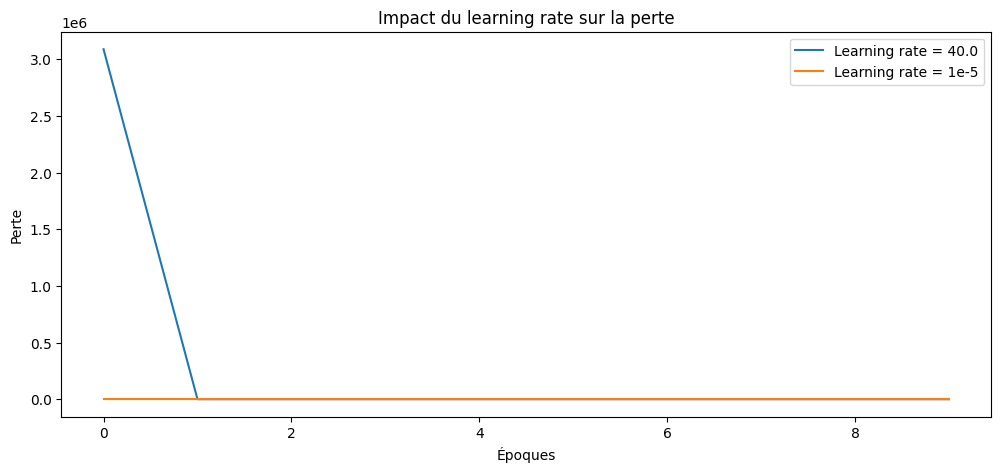

In [ ]:
# On trace juste la perte pour voir l'effet.

plt.figure(figsize=(12,5))

plt.plot(history_lr_high.history['loss'], label='Learning rate = 40.0')
plt.plot(history_lr_low.history['loss'], label='Learning rate = 1e-5')
plt.title("Impact du learning rate sur la perte")
plt.xlabel("Époques")
plt.ylabel("Perte")
plt.legend()

plt.show()

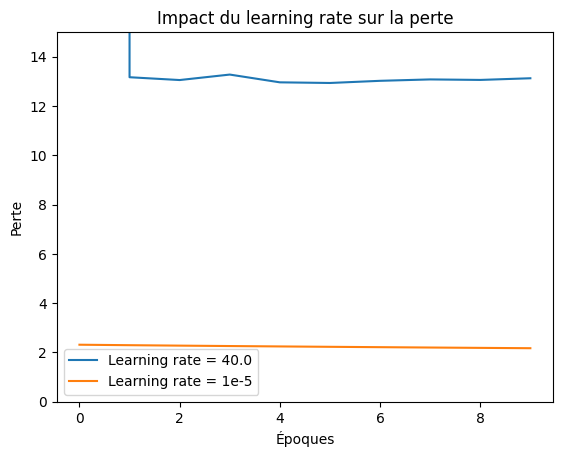

In [ ]:
# même graphe + zoom
plt.plot(history_lr_high.history['loss'], label='Learning rate = 40.0')
plt.plot(history_lr_low.history['loss'], label='Learning rate = 1e-5')

plt.title("Impact du learning rate sur la perte")
plt.xlabel("Époques")
plt.ylabel("Perte")

# Définir la limite de l'axe Y pour zoomer sur une portion plus petite
plt.ylim(0, 15)  # Ajustez les valeurs selon ce que vous souhaitez observer de plus près

plt.legend()
plt.show()

## Analyse

- **Learning rate trop élevé (40.0)** : La perte ne diminue probablement pas, ou elle fluctue fortement. Le pas de mise à jour est trop grand, donc on 'saute' autour du minimum, voire on diverge complètement.

- **Learning rate trop faible (1e-5)** : La perte diminue très lentement. En 3 époques, quasiment aucun progrès. Il faudrait un grand nombre d’époques pour voir une amélioration.

Trouver un bon taux d’apprentissage est crucial. On utilise souvent des techniques pour ajuster ce taux, ou on opte pour des optimisateurs adaptatifs comme Adam.

## Conclusion

Dans cette session, nous avons :

- Rappelé le forward pass.
- Approfondi le backpropagation : calcul du gradient, mise à jour des poids.
- Étudié différentes stratégies de descente de gradient (batch, stochastique, mini-batch).
- Observé l’impact du learning rate.
- Noté la question de convexité : la fonction de coût n’est pas convexe, et trouver le minimum global n’est pas garanti, mais la descente de gradient fonctionnne souvent bien dans la pratique.

Ces notions sont fondamentales pour comprendre et entraîner des réseaux neuronaux plus complexes. Dans les prochaines sessions, nous pourrions voir des optimisateurs plus avancés (Adam, RMSProp), la régularisation (pour lutter contre le surapprentissage), ou les réseaux de neurones convolutifs (CNN) pour le traitement d’images.

En attendant, vous pouvez expérimenter avec différents learning rates, architectures, et voir comment les performances évoluent.